# Running experiments on a cluster with `param_search`

This Python package makes it easy to launch lots of jobs with different parameters to a computing cluster. It also has features to monitor the status of running or completed jobs, aggregate their output, and create some basic visualizations.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append(os.environ['LIGAN_ROOT'])
import param_search
os.getcwd()

'/net/pulsar/home/koes/mtr22/ipython-notebooks'

## 1) Create a template job script
This is the script that you want to evaluate using ranges of different parameters. The parameters are specified as Python string formatting fields, i.e. using curly braces. There are also two optional built-in fields, `job_name` and `job_params`. The `job_name` field will be filled in with a parameterized job name, and the `job_params` field will be replaced by a comment block that displays what parameters were used to create each script.

In [2]:
template_file = 'my_job.sh'
template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
{job_params}
product=$(({term1}*{term2}))
echo "product\n$product" > $SLURM_JOB_ID.output
'''
with open(template_file, 'w') as f:
    f.write(template)

## 2) Define the parameter search space

Use the `ParamSpace` object to define the ranges of values for the parameters you want to explore. It is a subclass of `OrderedDict` that expects each key to be assigned as either a single value or iterable of values (strings are considered single values). Then, iterating over the `ParamSpace` produces parameter assignments from the Cartesian product over the defined parameter ranges.

In [3]:
param_space = param_search.ParamSpace(
    term1=range(4),
    term2=range(4),
)
list(param_space)

[Params([('term1', 0), ('term2', 0)]),
 Params([('term1', 0), ('term2', 1)]),
 Params([('term1', 0), ('term2', 2)]),
 Params([('term1', 0), ('term2', 3)]),
 Params([('term1', 1), ('term2', 0)]),
 Params([('term1', 1), ('term2', 1)]),
 Params([('term1', 1), ('term2', 2)]),
 Params([('term1', 1), ('term2', 3)]),
 Params([('term1', 2), ('term2', 0)]),
 Params([('term1', 2), ('term2', 1)]),
 Params([('term1', 2), ('term2', 2)]),
 Params([('term1', 2), ('term2', 3)]),
 Params([('term1', 3), ('term2', 0)]),
 Params([('term1', 3), ('term2', 1)]),
 Params([('term1', 3), ('term2', 2)]),
 Params([('term1', 3), ('term2', 3)])]

## 3) Setup parameterized job scripts
The `setup` function fills in the parameter fields in the template script with each parameter assignment in the parameter space, then writes out each of these parameterized job scripts to a separate subdirectory. The subdirectories are named according to a Python formatting string `name_format`, which is also used to fill in the `job_name` field in the template script.

In [4]:
job_files = param_search.setup(
    expt_dir='my_experiment',
    name_format='multiply_{term1}_{term2}',
    template_file=template_file,
    param_space=param_space
)
job_files

['my_experiment/multiply_0_0/my_job.sh',
 'my_experiment/multiply_0_1/my_job.sh',
 'my_experiment/multiply_0_2/my_job.sh',
 'my_experiment/multiply_0_3/my_job.sh',
 'my_experiment/multiply_1_0/my_job.sh',
 'my_experiment/multiply_1_1/my_job.sh',
 'my_experiment/multiply_1_2/my_job.sh',
 'my_experiment/multiply_1_3/my_job.sh',
 'my_experiment/multiply_2_0/my_job.sh',
 'my_experiment/multiply_2_1/my_job.sh',
 'my_experiment/multiply_2_2/my_job.sh',
 'my_experiment/multiply_2_3/my_job.sh',
 'my_experiment/multiply_3_0/my_job.sh',
 'my_experiment/multiply_3_1/my_job.sh',
 'my_experiment/multiply_3_2/my_job.sh',
 'my_experiment/multiply_3_3/my_job.sh']

## 4) Submit job scripts to cluster
The `submit` function submits a list of job scripts to a computing cluster with Slurm or Torque. It returns the job IDs associated with each submitted job.

In [5]:
job_ids = param_search.submit(job_files)
job_ids

[5511252,
 5511253,
 5511254,
 5511255,
 5511256,
 5511257,
 5511258,
 5511259,
 5511260,
 5511261,
 5511262,
 5511263,
 5511264,
 5511265,
 5511266,
 5511267]

## 5) Monitor status of queued jobs
The `status` function checks the current status of a list of jobs in a Slurm or Torque computing cluster.

In [6]:
param_search.status(job=','.join(map(str, job_ids)))

,job_id,queue,job_name,user,job_state,runtime,walltime,node_id,work_dir


## 6) Check completed jobs for errors
The `errors` function reads stderr files for the most recent submission of a list of job scripts and parses them for error messages.

In [7]:
errors = param_search.errors(job_files)
errors

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## 7) Aggregate completed job output
The `output` function reads csv-style output files for a list of job scripts, concatenates them, and indexes them with the job parameters.

In [8]:
output = param_search.output(job_files)
output

product
term1 term2 job_name             
0     0     multiply_0_0        0
      1     multiply_0_1        0
      2     multiply_0_2        0
      3     multiply_0_3        0
1     0     multiply_1_0        0
      1     multiply_1_1        1
      2     multiply_1_2        2
      3     multiply_1_3        3
2     0     multiply_2_0        0
      1     multiply_2_1        2
      2     multiply_2_2        4
      3     multiply_2_3        6
3     0     multiply_3_0        0
      1     multiply_3_1        3
      2     multiply_3_2        6
      3     multiply_3_3        9

## 8) Plot output with respect to parameters
The `plot` function allows you visualize the effect of parameters on job output metrics. It plots each `y` variable against each `x` variable on a separate axes, grouping by all of the other `x` variables. This grouping can be turned off by specifying a different value for the `hue` argument.

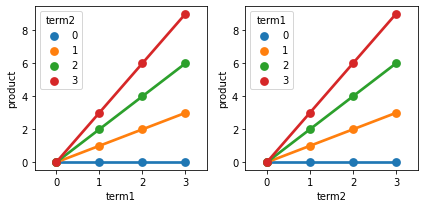

In [9]:
x = param_space.keys()
y = output.columns
fig = param_search.plot(output, x, y)